**LAB: SENTIMENT ANALYSIS - Unsupervised Machine Learning (Lexocon-based)**

We will work with the same movie reviews data we used for sentiment analysis with supervised machine learning. 

IMPORTANT: This time, the data are being stored in two "pickled" pandas dataframes, one for all training data and one for all testing data. We will use just the test data.

To get the data:

1- Download the "movie reviews" folder from here: https://www.dropbox.com/sh/4ln8ihzfsbwz3g2/AAC5kQXjcK87KllxYpZJr0-Wa?dl=0

2- Look inside the folder to see how the data are organized.

3- Set the path to the "movie reviews" folder on your machine:

In [9]:
path = '/Users/corrine/Documents/Data Courses/Text Mining/movie_reviews/'

We will use some functions for text pre-processing defined in Text_Normalization_Function.ipynb. Make sure that file is located in the same folder as the current Jupyter notebook (or include path to the file in the line below):

In [2]:
%run ./Text_Normalization_Function.ipynb

Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  ['<', 'p', '>', 'The', 'circus', 'dog', 'in', 'a', 'plissé', 'skirt', 'jumped', 'over', 'Python', 'who', 'was', "n't", 'that', 'large', ',', 'just', '3', 'feet', 'long.', '<', '/p', '>']
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  <p>The circus dog in a plissé skirt jumped over Python who was not that large, just 3 feet long.</p>
Original:   <p>The circus dog in a plissé skirt jumped over Python who wasn't that large, just 3 feet long.</p>
Processed:  [('<', 'a'), ('p', 'n'), ('>', 'v'), ('the', None), ('circus', 'n'), ('dog', 'n'), ('in', None), ('a', None), ('plissé', 'n'), ('skirt', 'n'), ('jumped', 'v'), ('over', None), ('python', 'n'), ('who', None), ('was', 'v'), ("n't", 'r'), ('that', None), ('large', 'a'), (',', None), ('just', 'r'), ('3', None), ('feet', 'n'), ('long.', 'a'), 

Import the required modules:

In [3]:
import pandas as pd
import numpy as np
import sys
import nltk
import warnings
warnings.simplefilter(action='ignore')

We will use the VADER lexicon available in NLTK module. You can read a very detailed information on how VADER was created here: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

Let's download the VADER lexicon and set up the sentiment analysis function that uses that lexicon:

In [5]:
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/corrine/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Let's explore how VADER assigns sentiment using the simple sentences below (feel free to play around with the sentences!):

In [6]:
text_1 = 'I really loved the plot of this movie'
text_2 = 'I really hated the plot of this movie'
text_3 = 'I really hated the plot of this movie :('

The results are below. The **'compound'** score is the overall sentiment polarity/intensity ranging from -1 to 1:

In [7]:
print(text_1, "\nScores (Vander):", analyzer.polarity_scores(text_1),"\n")
print(text_2, "\nScores (Vander):", analyzer.polarity_scores(text_2),"\n")
print(text_3, "\nScores (Vander):", analyzer.polarity_scores(text_3),"\n")

I really loved the plot of this movie 
Scores (Vander): {'neg': 0.0, 'neu': 0.589, 'pos': 0.411, 'compound': 0.6361} 

I really hated the plot of this movie 
Scores (Vander): {'neg': 0.428, 'neu': 0.572, 'pos': 0.0, 'compound': -0.6697} 

I really hated the plot of this movie :( 
Scores (Vander): {'neg': 0.552, 'neu': 0.448, 'pos': 0.0, 'compound': -0.8122} 



Now, let's load the movie reviews data:

In [10]:
test_data = pd.read_pickle(path + 'mreviews_test.pkl')
print(test_data.head())

    file_name                                        review_text  polarity
0    0_10.txt  I went and saw this movie last night after bei...  positive
0  100_10.txt  The finest short I've ever seen. Some commenta...  positive
0   101_9.txt  This is a very, very odd film...one that is so...  positive
0   102_8.txt  Although Bullet In The Brain is, without quest...  positive
0  103_10.txt  ...means "take up and read", which is precisel...  positive


Split the dataframe into reviews text and reviews polarity:

In [11]:
test_reviews = np.array(test_data['review_text'])
test_sentiments = np.array(test_data['polarity'])

Have a look at a couple of reviews and the sentiment polarity labels created by humans:

In [12]:
sample_docs = [100, 700]

for doc_index in sample_docs:
    print('Review:-')
    print(test_reviews[doc_index])
    print('Actual Labeled Sentiment:', test_sentiments[doc_index])
    print()

Review:-
The entire movie, an artful adaptation of one of Joyce's "Dubliners" stories, takes place on the night of January 6 (Epiphany), 1906. Most of the film takes place at an annual party given by three spinsters (two sisters and their niece), where a group of upper-class Dubliners gather for an evening of music, recitations and dinner. While there is very little plot per se, the interaction and conversation among the group reveals much about Dublin in the early 20th century when the stirrings for independence were just beginning. The cast, all talented Irish stage actors with the exception of Anjelica Huston, are universally wonderful, and one actually feels he is a guest at the gathering himself. The poignant final scene, between Ms. Huston and the amazing Donal McCann, reveals much about the marriage of the characters. There is poignancy mixed with humor and insight, and for those who like quiet, thoughtful movies, "The Dead" is highly recommended. My wife is from Dublin, we make

Let's create a function that scores text using VADER lexicon. The function will return the raw polarity/intensity score and the binary sentiment indicator (positive/negative). The function will use the following rule for assigning binary sentiment: if "compound" polarity/intensity score > 0.1 then the review is positive. The threshold of 0.1 is the recommended value.

In [13]:
def analyze_sentiment_vader_lexicon(review, 
                                    threshold = 0.1,
                                    verbose = False):
    
    #pre-process text
    review = normalize_accented_characters(review)
    review = html_parser.unescape(review)
    review = strip_html(review)
    
    #analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    
    #get binary sentiment
    binary_sentiment = 'positive' if scores['compound'] >= threshold\
                                   else 'negative'
    
    if verbose:
        
        #display sentiment 
        sentiment_frame = pd.DataFrame([[binary_sentiment, round(scores['compound'], 2)]],
                                        columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                                                      ['Binary Sentiment ', 'Polarity Score']], 
                                                              labels=[[0,0],[0,1]]))
        print(sentiment_frame.to_string(index=False))
    
    return binary_sentiment,scores['compound']  

Now we can apply the function to the sample documents:

In [14]:
for doc_index in sample_docs:
    print('Review:-')
    print(test_reviews[doc_index])
    print('Actual Labeled Sentiment:', test_sentiments[doc_index])    
    print()    
    final_sentiment = analyze_sentiment_vader_lexicon(test_reviews[doc_index],
                                                        threshold=0.1,
                                                        verbose=True)
    print('-'*60)                                                      

Review:-
The entire movie, an artful adaptation of one of Joyce's "Dubliners" stories, takes place on the night of January 6 (Epiphany), 1906. Most of the film takes place at an annual party given by three spinsters (two sisters and their niece), where a group of upper-class Dubliners gather for an evening of music, recitations and dinner. While there is very little plot per se, the interaction and conversation among the group reveals much about Dublin in the early 20th century when the stirrings for independence were just beginning. The cast, all talented Irish stage actors with the exception of Anjelica Huston, are universally wonderful, and one actually feels he is a guest at the gathering himself. The poignant final scene, between Ms. Huston and the amazing Donal McCann, reveals much about the marriage of the characters. There is poignancy mixed with humor and insight, and for those who like quiet, thoughtful movies, "The Dead" is highly recommended. My wife is from Dublin, we make

Let's score all movie reviews in the test dataset:

In [15]:
predicted_sentiment_test = pd.DataFrame([analyze_sentiment_vader_lexicon(review, threshold=0.1)
                     for review in test_reviews],columns = ['binary sentiment','raw score'])

In [16]:
predicted_sentiment_test.head()

,binary sentiment,raw score
0,positive,0.7956
1,positive,0.9818
2,positive,0.8265
3,positive,0.4282
4,positive,0.9850


Have a look at the accuracy and the confusion matrix. 

In [17]:
from sklearn import metrics

print('ACCURACY:', np.round(metrics.accuracy_score(test_sentiments, predicted_sentiment_test['binary sentiment']), 3),"\n")

print('CONFUSION MATRIX:')
pd.crosstab(pd.Series(test_sentiments), 
            pd.Series(predicted_sentiment_test['binary sentiment']), 
            rownames = ['True'], 
            colnames = ['Predicted'], 
            margins = True)

ACCURACY: 0.7 

CONFUSION MATRIX:


Predicted,negative,positive,All
True,,,
negative,270,230,500
positive,70,430,500
All,340,660,1000


**EXERCISE 1:** 

**a. Do you remember what was the accuracy rate when you trained a support vector machine model during our last lab? It was higher, right? What could be the reason?**
There might be some normalization issue as we can see from the compound score shown.

**b. What is this sentiment analysis tool's precision (true positives / (true positives + false positives))?** 
430 / 660 = 0.65

**c. What is its recall rate (true positives / (true positives + false negatives))?**
430 / 500 = 0.86

Have a look at raw palrity/intensity scores assigned to positive reviews:

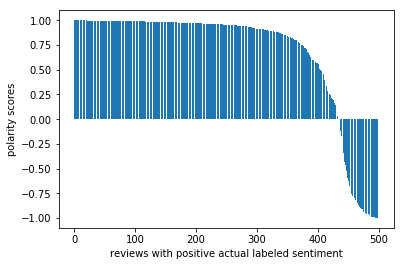

In [18]:
import matplotlib.pyplot as plt

x = range(0, 500)
pos_reviews_scored = predicted_sentiment_test[:500]['raw score']
plt.bar(x, pos_reviews_scored.sort_values(ascending=False))
plt.xlabel("reviews with positive actual labeled sentiment")
plt.ylabel("polarity scores")
plt.show()

Now, have a look at the raw polarity/intensity scores assigned to negative reviews:

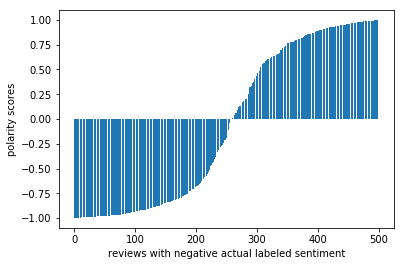

In [19]:
x = range(0, 500)
neg_reviews_scored = predicted_sentiment_test[500:1000]['raw score']
plt.bar(x, neg_reviews_scored.sort_values(ascending=True))
plt.xlabel("reviews with negative actual labeled sentiment")
plt.ylabel("polarity scores")
plt.show()

Define a function that computes accuracy rate for different value of the threshold (the threshold was set to 0.1 in our original analysis):

In [20]:
def try_threshold(polarity_scores, threshold_for_pos):
    binary_scores = ['positive' if s >= threshold_for_pos
                                   else 'negative' for s in list(polarity_scores)]
    accuracy = metrics.accuracy_score(test_sentiments, binary_scores)
    return(accuracy) 


Aplly this function to score the movie reviews using the threshold value = 0.5:

In [21]:
threshold = 0.5
print("Accuracy rate: ", try_threshold(predicted_sentiment_test['raw score'],threshold))


Accuracy rate:  0.712


Explore the changes in accuracy rate for a range of thresholds from -1 to 1:

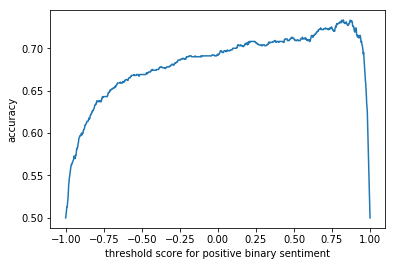

In [22]:
thresholds = np.linspace(-1,1,1000)
acc = [try_threshold(predicted_sentiment_test['raw score'],threshold) for threshold in thresholds]

plt.plot(thresholds, acc)
plt.xlabel("threshold score for positive binary sentiment")
plt.ylabel("accuracy")
plt.show()

**EXERCISE 2:**

**a. What is the threshold value that maximizes the prediction accuracy rate?**

around 0.8

**b. What is the threshold value that maximizes the precision of the prediction? What about the recall?**
-1 for recall score, and 1 for precision score.

For question b, you can re-define the function "try_threshold" to make use of the following lines that utilize functions recall_score and precision_score:

print('Recall:', np.round(metrics.recall_score(test_sentiments, 
                                               binary_scores,
                                               pos_label='positive'), 3),"\n")

print('Recall:', np.round(metrics.precision_score(test_sentiments, 
                                               binary_scores,
                                               pos_label='positive'), 3),"\n")

In [29]:
def try_threshold(polarity_scores, threshold_for_pos):
    binary_scores = ['positive' if s >= threshold_for_pos
                                   else 'negative' for s in list(polarity_scores)]
    accuracy = np.round(metrics.recall_score(test_sentiments, 
                                               binary_scores,
                                               pos_label='positive'), 3)
    return(accuracy) 


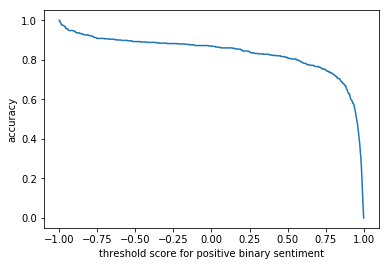

In [30]:
thresholds = np.linspace(-1,1,1000)
acc = [try_threshold(predicted_sentiment_test['raw score'],threshold) for threshold in thresholds]

plt.plot(thresholds, acc)
plt.xlabel("threshold score for positive binary sentiment")
plt.ylabel("accuracy")
plt.show()

In [31]:
def try_threshold(polarity_scores, threshold_for_pos):
    binary_scores = ['positive' if s >= threshold_for_pos
                                   else 'negative' for s in list(polarity_scores)]
    accuracy = np.round(metrics.precision_score(test_sentiments, 
                                               binary_scores,
                                               pos_label='positive'), 3)
    return(accuracy) 


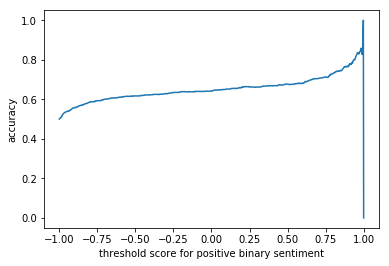

In [32]:
thresholds = np.linspace(-1,1,1000)
acc = [try_threshold(predicted_sentiment_test['raw score'],threshold) for threshold in thresholds]

plt.plot(thresholds, acc)
plt.xlabel("threshold score for positive binary sentiment")
plt.ylabel("accuracy")
plt.show()